In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import preprocessing
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import preprocessing
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Embedding, Dense, Dropout, Conv1D, GlobalMaxPooling1D, concatenate, Bidirectional, LSTM
from sklearn.metrics import confusion_matrix

In [2]:
df = pd.read_csv('D:/LikeLion/Code/Project2/Data/spell_check.csv', encoding='utf-8')

In [3]:
df = df[df['label'] != 2]

In [4]:
with open('D:/LikeLion/Code/Project2/Data/stopwords.txt', 'r', encoding='utf-8') as f:
    list_file = f.readlines()
stopwords = [line.rstrip('\n') for line in list_file] 

def remove_stopwords(text):
    ''' 불용어 제거 함수

    Arg:
        text: 개별 문서를 원소로 하는 리스트

    Return:
        개별 문서를 불용어를 제거한 것을 원소로 하는 리스트
    '''
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stopwords:
            final_text.append(i.strip())
    return " ".join(final_text)


In [5]:
# df['sentence'] = df['sentence'].apply(remove_stopwords)

In [6]:
x_train, x_test, y_train, y_test = train_test_split(df['sentence'], df['label'], test_size = 0.2, shuffle=True, random_state=119)
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(31931,) (7983,)
(31931,) (7983,)


In [7]:
features = x_train.tolist()
label = y_train.tolist()
test_features = x_test.tolist()
test_label = y_test.tolist()

In [8]:
# 단어 인덱스 시퀀스 벡터
train_corpus = [preprocessing.text.text_to_word_sequence(text) for text in features]
train_tokenizer = preprocessing.text.Tokenizer()
train_tokenizer.fit_on_texts(train_corpus)
train_sequences = train_tokenizer.texts_to_sequences(train_corpus)

In [9]:
# 단어 인덱스 시퀀스 벡터
test_corpus = [preprocessing.text.text_to_word_sequence(text) for text in test_features]
test_tokenizer = preprocessing.text.Tokenizer()
test_tokenizer.fit_on_texts(test_corpus)
test_sequences = test_tokenizer.texts_to_sequences(test_corpus)

In [10]:
print('리뷰의 최대 길이 :',max(len(l) for l in train_sequences))
print('리뷰의 평균 길이 :',sum(map(len, train_sequences))/len(train_sequences))

리뷰의 최대 길이 : 78
리뷰의 평균 길이 : 5.0703391688327955


In [11]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [12]:
max_len = 70
below_threshold_len(max_len, train_sequences)

전체 샘플 중 길이가 70 이하인 샘플의 비율: 99.99373649431587


In [13]:
word_index = train_tokenizer.word_index
# print(word_index)

In [14]:
MAX_SEQ_LEN = 70

In [15]:
train_x = preprocessing.sequence.pad_sequences(train_sequences, maxlen=MAX_SEQ_LEN, padding='post')
train_y = to_categorical(label, num_classes=2)

test_x = preprocessing.sequence.pad_sequences(test_sequences, maxlen=MAX_SEQ_LEN, padding='post' )
test_y = to_categorical(test_label, num_classes=2)

In [16]:
# 학습용, 검증용, 테스트용 데이터셋 생성
# ds = tf.data.Dataset.from_tensor_slices((padded_seq, labels))
# ds = ds.shuffle(len(features))

# train_size = int(len(padded_seq) * 0.7)
# val_size = int(len(padded_seq) * 0.2)
# test_size = int(len(padded_seq) * 0.1)

# train_ds = ds.take(train_size).batch(20)
# val_ds = ds.skip(train_size).take(val_size).batch(20)
# test_ds = ds.skip(train_size + val_size).take(test_size).batch(20)

In [17]:
model = tf.keras.Sequential([
    Embedding(len(word_index)+1, 100, input_length = MAX_SEQ_LEN),
    Bidirectional(LSTM(128, return_sequences=True)),
    Conv1D(filters=128, kernel_size=4, padding='same', activation='relu'),
    GlobalMaxPooling1D(),
    Dropout(0.2),
    # Bidirectional(LSTM(64, return_sequences=True)),
    Dense(128, activation='relu'),
    Dense(2, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.01), metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 70, 100)           2394900   
_________________________________________________________________
bidirectional (Bidirectional (None, 70, 256)           234496    
_________________________________________________________________
conv1d (Conv1D)              (None, 70, 128)           131200    
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2

In [19]:
es = EarlyStopping(monitor='val_loss', verbose=1, patience=2, mode='min')

In [20]:
history = model.fit(train_x, train_y, validation_split=0.2, epochs=10, batch_size=128, callbacks = [es])

Epoch 1/10
200/200 [==============================] - 38s 182ms/step - loss: 0.2999 - accuracy: 0.8770 - val_loss: 0.1724 - val_accuracy: 0.9369
Epoch 2/10
200/200 [==============================] - 37s 186ms/step - loss: 0.0704 - accuracy: 0.9778 - val_loss: 0.1753 - val_accuracy: 0.9346
Epoch 3/10
200/200 [==============================] - 35s 176ms/step - loss: 0.0396 - accuracy: 0.9889 - val_loss: 0.2955 - val_accuracy: 0.9300
Epoch 00003: early stopping


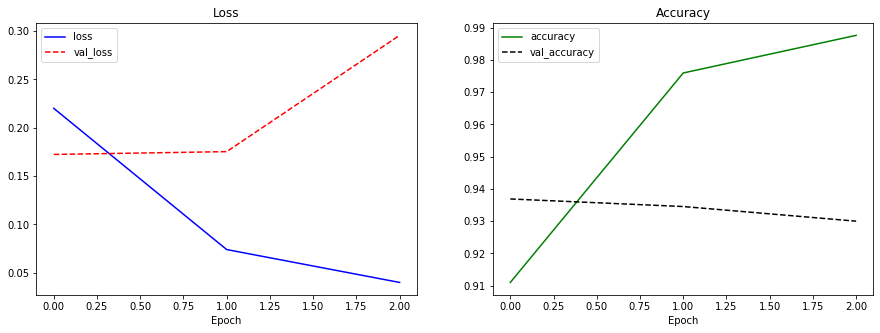

In [22]:
plt.figure(figsize=(15,5))
plt.title('CNN_BiLSTM')

plt.subplot(1,2,1)
plt.title('Loss')
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1,2,2)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'], 'k--', label='val_accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.show()

In [23]:
loss, accuracy = model.evaluate(test_x, test_y)

250/250 [==============================] - 4s 18ms/step - loss: 1.0871 - accuracy: 0.7430


In [27]:
def make_confusion(y_test, y_pred):
    confusion = confusion_matrix(y_test,y_pred)
    confusion_df = pd.DataFrame(confusion,columns=['Predicted_Negative','Predicted_Positive'],index=['Actual_Negative','Actual_Positive'])
    
    return confusion_df

In [28]:
y_pred = model.predict(test_x)
y_pred = np.argmax(y_pred, axis=1)
conf_mat = make_confusion(test_label, y_pred)

In [29]:
conf_mat

,Predicted_Negative,Predicted_Positive
Actual_Negative,568,963
Actual_Positive,1089,5363
